Script to analyze the results on real datasets. This includes plotting the consensus tree and gene expression analysis.

In [340]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pygraphviz as pgv
import seaborn as sns
import os
from collections import Counter
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from dendropy import Tree, TreeList, TaxonNamespace

# from generate_results_python_r.data_analysis import all_global_parameters
from src_python.cell_tree import CellTree

In [341]:
study_num = "mm16" # bc03 bc07 mm16 mm34
primary_cells = []

if study_num == "bc03":
    primary_cells = ["SRR5023442", "SRR5023443", "SRR5023444", "SRR5023445", "SRR2973275", "SRR2973351", "SRR2973352", "SRR2973353", "SRR2973354", "SRR2973355", "SRR2973356", "SRR2973357", "SRR2973358", "SRR2973359", "SRR2973360", "SRR2973361", "SRR2973362", "SRR2973363", "SRR2973364", "SRR2973365", "SRR2973366", "SRR2973367", "SRR2973368", "SRR2973369", "SRR2973370", "SRR2973371", "SRR2973372", "SRR2973373", "SRR2973374", "SRR2973375", "SRR2973376", "SRR2973377", "SRR2973378", "SRR2973379", "SRR2973380", "SRR2973381", "SRR2973382", "SRR2973383"]

if study_num == "bc07":
    primary_cells =  ["SRR2973484", "SRR5023558", "SRR5023559", "SRR5023560", "SRR2973277", "SRR2973437", "SRR2973438", "SRR2973439", "SRR2973440", "SRR2973441", "SRR2973442", "SRR2973443", "SRR2973444", "SRR2973445", "SRR2973446", "SRR2973447", "SRR2973448", "SRR2973449", "SRR2973450", "SRR2973451", "SRR2973452", "SRR2973453", "SRR2973454", "SRR2973455", "SRR2973456", "SRR2973457", "SRR2973458", "SRR2973459", "SRR2973460", "SRR2973461", "SRR2973462", "SRR2973463", "SRR2973464", "SRR2973465", "SRR2973466", "SRR2973467", "SRR2973468", "SRR2973469", "SRR2973470", "SRR2973471", "SRR2973472", "SRR2973473", "SRR2973474", "SRR2973475", "SRR2973476", "SRR2973477", "SRR2973478", "SRR2973479", "SRR2973480", "SRR2973481", "SRR2973482", "SRR2973483"]

if study_num == "mm34":
    primary_cells = ["SRR6710302", "SRR6710303", "SRR6710304", "SRR6710305", "SRR6710306", "SRR6710307", "SRR6710308", "SRR6710309", "SRR6710310", "SRR6710311", "SRR6710312", "SRR6710313", "SRR6710314", "SRR6710315", "SRR6710316", "SRR6710317", "SRR6710318", "SRR6710319", "SRR6710320", "SRR6710321", "SRR6710322", "SRR6710323", "SRR6710324", "SRR6710325", "SRR6710326", "SRR6710327", "SRR6710328", "SRR6710329", "SRR6710330", "SRR6710331", "SRR6710332", "SRR6710333", "SRR6710334", "SRR6710335", "SRR6710336", "SRR6710337", "SRR6710338", "SRR6710339", "SRR6710340", "SRR6710341", "SRR6710342", "SRR6710343", "SRR6710344", "SRR6710345", "SRR6710346", "SRR6710347", "SRR6710348", "SRR6710349", "SRR6710350", "SRR6710351", "SRR6710352", "SRR6710353", "SRR6710354", "SRR6710355", "SRR6710356", "SRR6710357", "SRR6710358", "SRR6710359", "SRR6710360", "SRR6710361", "SRR6710362", "SRR6710363", "SRR6710364", "SRR6710365", "SRR6710366"]

if study_num == "mm16":
    primary_cells = ["SRR6710256", "SRR6710257", "SRR6710258", "SRR6710259", "SRR6710260", "SRR6710261", "SRR6710262", "SRR6710263", "SRR6710264", "SRR6710265", "SRR6710266", "SRR6710267", "SRR6710268", "SRR6710269", "SRR6710270", "SRR6710271", "SRR6710272", "SRR6710273", "SRR6710274", "SRR6710275", "SRR6710276", "SRR6710277", "SRR6710278"]

In [342]:
n_bootstrap = 1000
np.random.seed(0)
n_rounds = 3
model = "sciterna"

# create paths to save the trees
path = rf"../data/results/{study_num}/{model}"
os.makedirs(os.path.join(path, f"{model}_ct_trees"), exist_ok=True)
path_bootstrap = rf"../data/results/{study_num}/{model}_bootstrap"
os.makedirs(os.path.join(path_bootstrap, f"{model}_ct_trees"), exist_ok=True)

# load the read count data
ref = np.array(pd.read_csv(os.path.join(f"../data/input_data/{study_num}", "ref.csv")))
cell_names = list(ref[:,0])
cell_indices = [cell_names.index(item) for item in primary_cells if item in cell_names]
ref = ref[:, 1:].astype(int)
alt = np.array(pd.read_csv(os.path.join(f"../data/input_data/{study_num}", "alt.csv")))[:, 1:].astype(int)


# read and normalize the expression data
expression_counts = pd.read_csv(rf"../data/input_data/{study_num}/gene_expression_counts.csv", index_col=0)
normalized_counts = expression_counts.div(expression_counts.sum(axis=1), axis=0) * 1e5
expression_counts_scaled = np.log1p(normalized_counts)

# Can be used to visualize a specific gene on the tree structure
selected_gene = "CTSB"
expression_selected_gene = expression_counts_scaled[cell_names].loc[selected_gene]


# count the splits over all bootstrap samples
taxa = TaxonNamespace()
trees = TreeList(taxon_namespace=taxa)
split_counter = Counter()

def normalize_split(split):
    A, B = map(set, split)

    if len(A) < 2 or len(B) < 2:
        return None

    side1 = frozenset(A)
    side2 = frozenset(B)

    return frozenset([side1, side2])

def get_splits(ct, node, labels=None):
    splits = []
    for child in ct.dfs_experimental(node):
        if ct.isleaf(child):
            continue

        child_leaves = [leaf for leaf in ct.leaves(child)]
        other_partition = [leaf for leaf in labels if leaf not in child_leaves]

        if 0 < len(child_leaves) < len(labels):
            splits.append((child_leaves, other_partition))

    return splits

def to_newick(ct, node):
    if ct.isleaf(node):
        return f"{node}"
    children = ct.children(node)
    return "(" + ",".join(to_newick(ct, child) for child in children) + f"){node}"

for test in range(n_bootstrap):
    for i in range(n_rounds -1, n_rounds):
        path_parent = os.path.join(path_bootstrap, f"{model}_parent_vec", f"{model}_parent_vec_{i}r{test}.txt")
        path_mut_loc = os.path.join(path_bootstrap, f"{model}_mutation_location", f"{model}_mutation_location_{i}r{test}.txt")
        path_selected = os.path.join(path_bootstrap, f"{model}_selected_loci", f"{model}_selected_loci_{i}r{test}.txt")

        if not os.path.exists(path_parent) or not os.path.exists(path_mut_loc) or not os.path.exists(path_selected):
            continue

        parent_vec = np.loadtxt(path_parent, dtype=int)
        mut_locs = np.loadtxt(path_mut_loc, dtype=int)
        selected_mutations = np.loadtxt(path_selected, dtype=int)

        n_cells = int(((len(parent_vec)+1)/2))

        ct = CellTree(n_cells=n_cells, n_mut=len(selected_mutations))
        ct.use_parent_vec(parent_vec)

        newick_str = to_newick(ct, ct.main_root) + ";"
        tree = Tree.get(data=newick_str, schema="newick", taxon_namespace=taxa)
        trees.append(tree)

        # Count normalized splits
        labels = list(ct.leaves(ct.main_root))
        raw_splits = get_splits(ct, ct.main_root, labels)
        for split in raw_splits:
            norm = normalize_split(split)
            if norm is not None:
                split_counter[norm] += 1

In [343]:
def annotate_clade_frequencies(tree, split_counter, total_trees):
    """
    Annotates each internal node in the consensus tree with its clade frequency
    based on a user-provided split_counter.
    Frequencies are stored in node.label (string, formatted to 2 decimals).
    """
    for node in tree.postorder_node_iter():
        if node.is_leaf():
            continue

        # Get leaf labels on each side of the split
        node_leaves = set(int(leaf.taxon.label) for leaf in node.leaf_iter())
        rest_leaves = set(int(leaf.taxon.label) for leaf in tree.leaf_node_iter()) - node_leaves

        if len(node_leaves) < 2 or len(rest_leaves) < 2:
            continue  # Not a valid split

        split = frozenset([frozenset(node_leaves), frozenset(rest_leaves)])
        freq = split_counter.get(split, 0) / total_trees
        node.label = f"{freq:.3f}"

consensus_tree = trees.consensus(min_freq=0.01, resolve_polytomies=True, suppress_unifurcations=True)
consensus_tree.resolve_polytomies(update_bipartitions=False)
annotate_clade_frequencies(consensus_tree, split_counter, total_trees=n_bootstrap)
print(consensus_tree.as_ascii_plot(show_internal_node_labels=True))

                                                                     /----- 18
     /---------------------------------------------------------------0.189    
     |                                                               \----- 1 
     |                                                                        
     |                                                               /----- 11
     |                                                         /-----0.094    
     |                                                         |     \----- 8 
     |           /---------------------------------------------0.001          
     |           |                                             |     /----- 19
     |           |                                             \-----0.076    
     |           |                                                   \----- 14
     |           |                                                            
     |           |                                  

In [344]:
def tree_to_parent_vector(tree):
    """
    Converts a DendroPy Tree object to a parent vector.
    Leaf nodes retain their labels (assumed to be string representations of integers).
    Internal nodes are assigned new labels (as strings of integers) starting from the max leaf label + 1.

    Returns:
        parent_vector: list where index i contains the parent of node i (both as integers)
        node_index_map: dict mapping each node object to its string label
    """
    node_index_map = {}

    # Step 1: Assign leaf labels directly
    leaf_labels = [int(node.taxon.label) for node in tree.leaf_node_iter()]
    max_leaf_label = max(leaf_labels)

    for node in tree.leaf_node_iter():
        node_index_map[node] = node.taxon.label  # Keep leaf labels (as str)

    # Step 2: Assign numeric labels to internal nodes
    next_internal_label = max_leaf_label + 1
    for node in tree.postorder_node_iter():
        if node not in node_index_map:
            node_index_map[node] = str(next_internal_label)
            next_internal_label += 1

    # Step 3: Build parent mapping using labels
    parent_dict = {}
    for parent in tree.preorder_node_iter():
        parent_id = int(node_index_map[parent])
        for child in parent.child_node_iter():
            child_id = int(node_index_map[child])
            parent_dict[child_id] = parent_id

    # Step 4: Build the parent vector list
    total_nodes = next_internal_label
    parent_vector = [-1] * total_nodes  # Initialize with -1 for all nodes

    for child_id, parent_id in parent_dict.items():
        parent_vector[child_id] = parent_id

    return parent_vector, node_index_map

consensus_parent_vec, node_index_map = tree_to_parent_vector(consensus_tree)
print(consensus_parent_vec, len(consensus_parent_vec))

[83, 46, 81, 78, 83, 52, 73, 89, 47, 84, 72, 47, 89, 73, 48, 72, 78, 74, 46, 48, 68, 68, 82, 65, 59, 57, 76, 76, 81, 50, 56, 77, 60, 69, 61, 57, 66, 55, 53, 61, 50, 54, 51, 53, 59, 56, 88, 49, 49, 71, 51, 52, 67, 54, 55, 64, 58, 58, 63, 60, 62, 62, 63, 64, 65, 66, 67, 70, 69, 70, 71, 87, 75, 74, 75, 80, 77, 79, 79, 80, 86, 82, 85, 84, 85, 86, 87, 88, 90, 90, -1] 91


In [345]:
for split, count in split_counter.most_common(20):
    side1, side2 = list(split)
    shorter_side = sorted(side1) if len(side1) <= len(side2) else sorted(side2)
    print(f"Split: {shorter_side} appears in {count} of {n_bootstrap * (n_rounds - 2)} trees.")

Split: [24, 44] appears in 874 of 1000 trees.
Split: [24, 32, 44] appears in 750 of 1000 trees.
Split: [29, 40] appears in 673 of 1000 trees.
Split: [38, 41, 43] appears in 357 of 1000 trees.
Split: [38, 43] appears in 344 of 1000 trees.
Split: [23, 24, 25, 30, 32, 34, 35, 37, 38, 39, 41, 43, 44, 45] appears in 273 of 1000 trees.
Split: [6, 13] appears in 272 of 1000 trees.
Split: [26, 27] appears in 248 of 1000 trees.
Split: [24, 25, 30, 32, 34, 35, 37, 38, 39, 41, 43, 44, 45] appears in 246 of 1000 trees.
Split: [1, 18] appears in 189 of 1000 trees.
Split: [29, 40, 42] appears in 183 of 1000 trees.
Split: [26, 33] appears in 180 of 1000 trees.
Split: [20, 21] appears in 179 of 1000 trees.
Split: [5, 29, 40] appears in 162 of 1000 trees.
Split: [30, 35] appears in 160 of 1000 trees.
Split: [30, 45] appears in 160 of 1000 trees.
Split: [10, 15] appears in 157 of 1000 trees.
Split: [23, 39] appears in 155 of 1000 trees.
Split: [3, 42] appears in 151 of 1000 trees.
Split: [5, 42] appears

In [346]:
def plot_consensus_tree(parent_vector, path, support_thresholds=None, plot_gene_expression=False):
    """
    Plots the consensus tree using Graphviz with node color indicating gene expression (green shades)
    and node border indicating cell identity (red for primary, blue otherwise).

    Args:
        parent_vector (list): Vector where index is the node, value is its parent.
        path (str): Output directory for saving the rendered tree image.
        support_thresholds (dict): Mapping of internal node ids to support values.
    """
    n_cells = int((len(parent_vector) + 1) / 2)
    ct = CellTree(n_cells=n_cells, n_mut=0)
    ct.use_parent_vec(parent_vector)
    ct.mut_loc = []

    graph_branches = ct.to_graphviz()

    if plot_gene_expression:
        graph_branches.attr(label=f"Gene Expression: {selected_gene}", labelloc='top', fontsize='50')

    # Normalize expression values to [0, 1] for colormap
    expr_values = expression_selected_gene.values
    norm = mcolors.Normalize(vmin=min(expr_values), vmax=max(expr_values))
    cmap = plt.cm.Greens

    for node_id in range(len(parent_vector)):
        is_leaf = node_id < n_cells
        node_shape = 'circle'
        node_style = 'filled'

        if is_leaf:
            expr_value = expression_selected_gene[cell_names[node_id]]
            fillcolor = mcolors.to_hex(cmap(norm(expr_value)))

            border_color = 'red' if node_id in cell_indices else 'blue'

            if not plot_gene_expression:
                fillcolor = 'red' if node_id in cell_indices else 'blue'

            graph_branches.node(
                str(node_id),
                shape=node_shape,
                style=node_style,
                fillcolor=fillcolor,
                color=border_color,
                penwidth='4'
            )
        else:
            fillcolor = 'lightgrey'
            penwidth = 1

            if support_thresholds:
                support = support_thresholds.get(str(node_id), 0.0)
                penwidth = 25 * support

            graph_branches.node(
                str(node_id),
                shape=node_shape,
                style=node_style,
                fillcolor=fillcolor,
                color='black',
                penwidth=str(penwidth)
            )

    if plot_gene_expression:
        graph_branches.render(os.path.join(path, f"{model}_consensus_tree_{study_num}_{selected_gene}"), format='png', cleanup=True)
    else:
        graph_branches.render(os.path.join(path, f"{model}_consensus_tree_{study_num}"), format='svg', cleanup=True)
    return graph_branches, ct

support_thresholds = {}
for node in consensus_tree.postorder_node_iter():
    if not node.is_leaf():
        node_id = int(node_index_map[node])
        try:
            support = float(node.label)
            support_thresholds[str(node_id)] = support
        except (ValueError, TypeError):
            continue  # Skip if label isn't a number

graph, ct_consensus = plot_consensus_tree(consensus_parent_vec, path_bootstrap, support_thresholds=support_thresholds)

In [347]:
def plot_trees(inpath, test, plot_mutations=False, min_num=0):
    for i in range(min_num, n_rounds):
        path_parent = os.path.join(inpath, f"{model}_parent_vec", f"{model}_parent_vec_{i}{test}.txt")
        path_mut_loc = os.path.join(inpath, f"{model}_mutation_location", f"{model}_mutation_location_{i}{test}.txt")
        path_selected = os.path.join(inpath, f"{model}_selected_loci", f"{model}_selected_loci_{i}{test}.txt")

        parent_vec = np.loadtxt(path_parent, dtype=int)
        if os.path.exists(path_mut_loc) == False:
            mut_locs = []
            selected_mutations = []
        else:
            mut_locs = np.loadtxt(path_mut_loc, dtype=int)
            selected_mutations = np.loadtxt(path_selected, dtype=int)

        n_cells = int(((len(parent_vec)+1)/2))

        ct = CellTree(n_cells=n_cells, n_mut=len(selected_mutations))
        ct.use_parent_vec(parent_vec)

        if plot_mutations:
            ct.mut_loc = mut_locs
            graph = ct.to_graphviz()
            graph.render(os.path.join(inpath, f"{model}_ct_trees", f"ct_tree_{i}{test}"), format='png', cleanup=True)

        ct.mut_loc = []
        graph_branches = ct.to_graphviz()
        for n in range(n_cells):
            if n in cell_indices:
                graph_branches.node(str(n), shape='circle', style='filled', color="red")
            else:
                graph_branches.node(str(n), shape='circle', style='filled', color="blue") # metastasis

        graph_branches.render(os.path.join(inpath, f"{model}_ct_trees", f"ct_tree_{i}{test}_branches"), format='png', cleanup=True)

model = "sciterna"
plot_trees(path, f"r0", plot_mutations=True)

for i in range(1):
    plot_trees(path_bootstrap, f"r{i}", plot_mutations=False)

model = "sclineager"
plot_trees(rf"../data/results/{study_num}/{model}", "", plot_mutations=True, min_num = (n_rounds-1))
model = "dendro"
plot_trees(rf"../data/results/{study_num}/{model}", "", plot_mutations=True, min_num = (n_rounds-1))

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.59572 to fit
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.618584 to fit
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.584676 to fit


In [348]:
def get_node_positions(dot):
    """Get x-coordinates of all nodes from Graphviz layout."""
    A = pgv.AGraph(string=dot.source)
    A.layout(prog='dot')

    positions = {}
    for node in A.nodes():
        name = node.get_name()
        if not name.isdigit():
            continue
        pos = node.attr.get('pos')
        if pos:
            x, _ = map(float, pos.split(','))
            positions[int(name)] = x
    return positions

def dfs_left_to_right(graph, root, n_cells, positions):
    """
    Perform DFS traversal, prioritizing children with lower x-coordinates first.

    Args:
        graph: adjacency list {parent: [child1, child2, ...]}
        root: root node id (int)
        n_cells: number of leaves (int)
        positions: dict {node_id: x_pos}

    Returns:
        List of leaf node IDs in visual left-to-right DFS order.
    """
    leaf_order = []

    def dfs(node):
        children = graph.get(node, [])
        # Sort children by x-position
        children_sorted = sorted(children, key=lambda x: positions.get(x, float('inf')))
        if not children:
            if node < n_cells:  # leaf node condition
                leaf_order.append(node)
            return
        for child in children_sorted:
            dfs(child)

    dfs(root)
    return leaf_order

# Build adjacency list from parent vector
def build_adj_list(parent_vec):
    from collections import defaultdict
    adj = defaultdict(list)
    for child, parent in enumerate(parent_vec):
        if parent != -1:
            adj[parent].append(child)
    return adj

positions = get_node_positions(graph)
adj_list = build_adj_list(consensus_parent_vec)
root = max(set(consensus_parent_vec))

leaf_order = dfs_left_to_right(adj_list, root, n_cells, positions)

In [349]:
other_cell_names = [name for name in cell_names if name not in primary_cells]

# Subset expression data
primary_expr = expression_counts_scaled[primary_cells]
other_expr = expression_counts_scaled[other_cell_names]

# Compute mean expression per gene for each group
mean_primary = primary_expr.mean(axis=1)
mean_other = other_expr.mean(axis=1)

# Calculate absolute differences
expr_diff = (mean_primary - mean_other).abs()

# Sort and print top 20 genes with largest difference
top_diff_genes = expr_diff.sort_values(ascending=False).head(10)
print("Top 10 genes with largest normalized expression difference (primary vs other cells):")
print(top_diff_genes)

mean_total_expr = expression_counts_scaled.mean(axis=1)
top_expr_genes = mean_total_expr.sort_values(ascending=False).head(40)
print("Top 10 genes with highest mean normalized expression across all cells:")
print(top_expr_genes)

Top 10 genes with largest normalized expression difference (primary vs other cells):
IGHV5-51             8.053273
IGHV1OR21-1          7.600806
ENSG00000277574.1    7.465583
IGHV1OR15-4          7.268946
IGHV1OR16-3          7.188746
TIPARP               6.908683
EGR1                 6.891226
IGKV1OR22-5          6.834625
IGHV1-2              6.720328
EEF1A1P22            6.657719
dtype: float64
Top 10 genes with highest mean normalized expression across all cells:
MTRNR2L12            7.220191
MT-RNR2              7.181244
MTRNR2L8             7.108729
RPL21                6.889245
FTL                  6.864435
B2M                  6.858773
ENSG00000273686.2    6.827762
RP11-572P18.1        6.782425
RPS27                6.756396
MT-RNR1              6.744890
RPL21P119            6.729277
RPL21P75             6.727981
HNRNPH1              6.721544
EIF1                 6.721296
MALAT1               6.696661
RP11-50D9.1          6.690200
MT-CO1               6.672272
SERF2              

<Figure size 4000x1600 with 0 Axes>

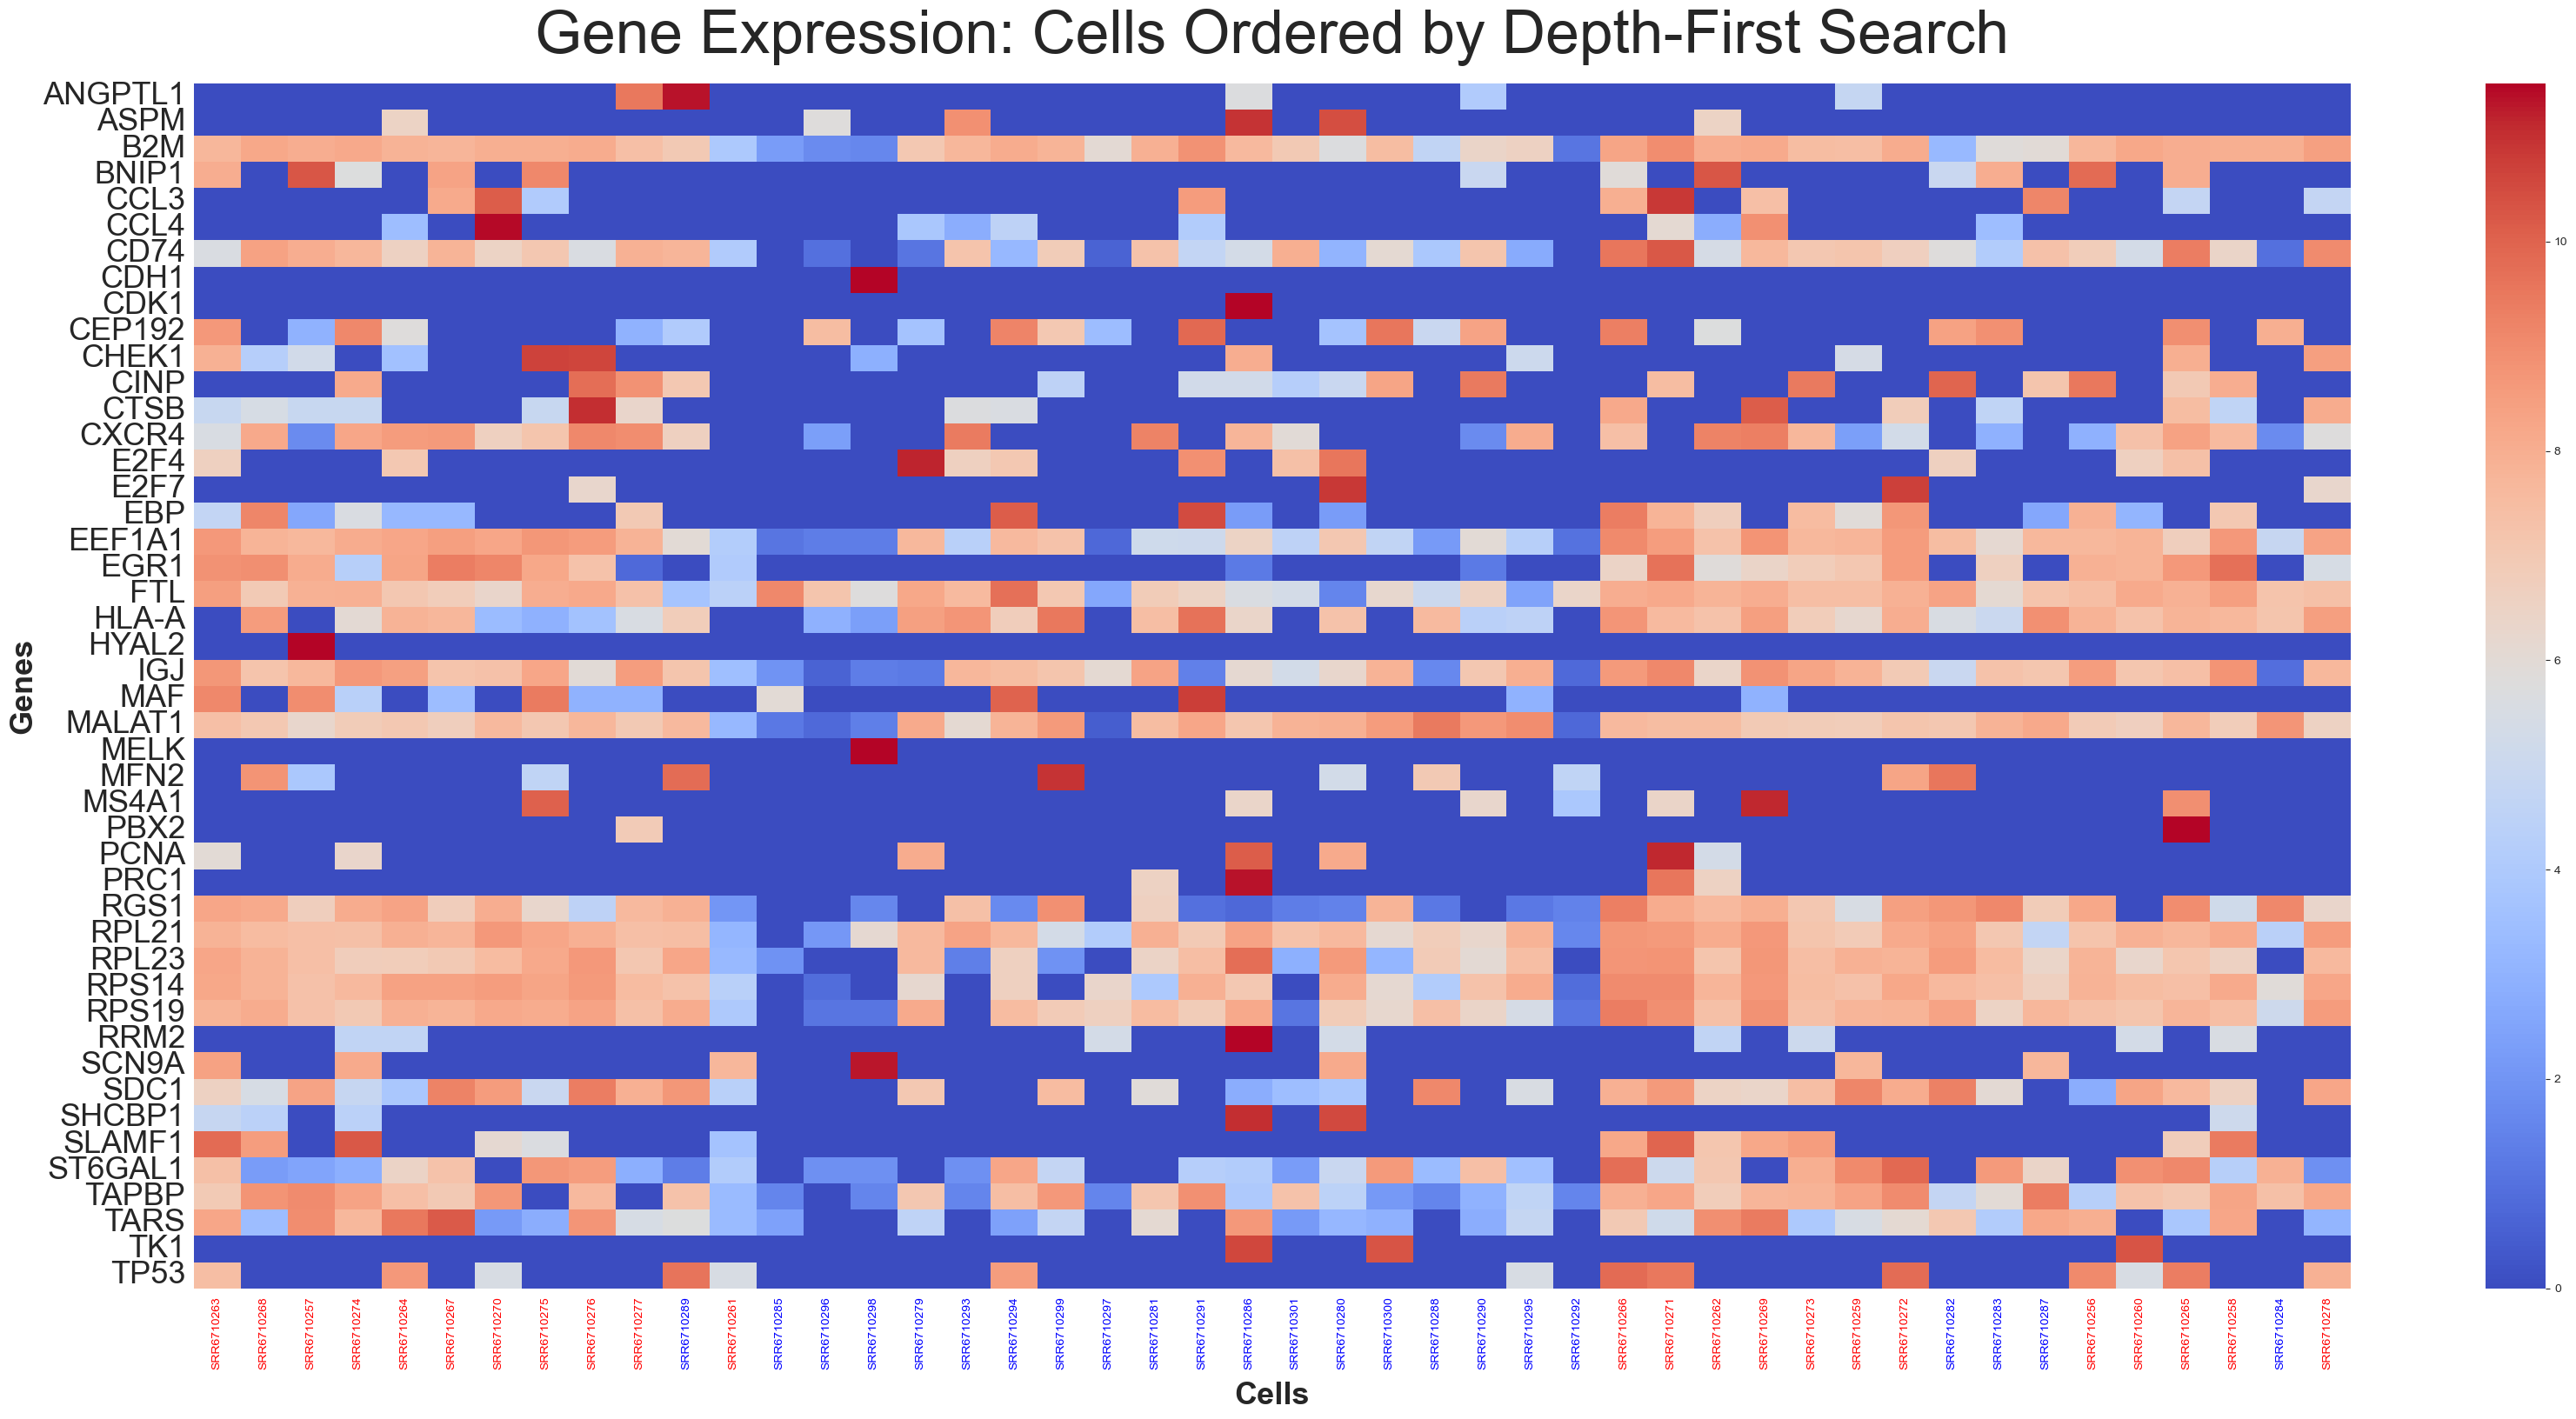

In [350]:
sorted_indices = leaf_order

plt.figure(figsize=(40, 16))

genes = top_expr_genes.index[:10]

if study_num[:2] == "bc":
    genes = ["CDH1", "ERBB2", "ESR1", "FBN1", "MS4A1", "PIK3CA", "PLAUR", "PTEN", "PTPRC", "TIGIT", "STK11", "SDC1", "CHEK2", "TP53", "PLEK", "ATM", "MYC", "KRAS", "NRAS", "MS4A1", "STAP1", "RPL35A"]

if study_num[:2] == "mm":
    genes = ["IGJ", "CTSB", "EGR1", "FTL", "MALAT1", "RPL21", "SDC1", "SLAMF1", "CDH1", "ETV7", "CXCR4", "E2F4", "ANGPTL1", "HYAL2", "PBX2", "SCN9A", "BNIP1", "MFN2", "CEP192", "TARS", "E2F7", "MELK", "CHEK1", "EBP", "CINP", "PCNA", "ASPM", "CDK1", "MAF", "TP53", "MS4A1", "RGS1", "ST6GAL1", "HLA-A", "TAPBP", "CD74", "B2M", "CCL3", "CCL4", "RPS14","RPS19", "RPL23", "EEF1A1", "TK1", "RRM2","SHCBP1", "PRC1"]

chosen_genes = expression_counts_scaled[expression_counts_scaled.index.isin(genes)]
sorted_df = chosen_genes.iloc[:, sorted_indices]

col_colors = ['red' if val in cell_indices else 'blue' for val in sorted_indices]

plt.figure(figsize=(40, 18))
ax = sns.heatmap(sorted_df, cmap='coolwarm')

for n, tick_label in enumerate(ax.get_xticklabels()):
    tick_label.set_color(col_colors[n])

for tick_label in ax.get_yticklabels():
    tick_label.set_fontsize(26)
    tick_label.set_rotation(0)

plt.title("Gene Expression: Cells Ordered by Depth-First Search", fontsize=50, pad=25)
plt.ylabel("Genes", fontsize=26, fontweight='bold')
plt.xlabel("Cells", fontsize=26, fontweight='bold', labelpad=10)
# plt.savefig(rf"../data/results/figures/gene_expression_{study_num}.svg", format="svg")
plt.show()

In [351]:
selected = np.loadtxt(os.path.join(path_bootstrap, "selected.txt"), delimiter=',', dtype=int)
ref = pd.read_csv(os.path.join(f"../data/input_data/{study_num}", "ref.csv"))

all_individual_overdispersions_h = np.full((n_bootstrap, ref.shape[1]), np.nan)
all_individual_dropouts = np.full((n_bootstrap, ref.shape[1]), np.nan)

for i in range(n_bootstrap):
    for j in range(n_rounds-1, n_rounds):
        selected_mutations = np.loadtxt(os.path.join(path_bootstrap, "sciterna_selected_loci", f"sciterna_selected_loci_{j}r{i}.txt"), dtype=int)
        individual_dropouts = np.loadtxt(os.path.join(path_bootstrap, "sciterna_individual_dropout_probs", f"sciterna_individual_dropout_probs_{j}r{i}.txt"))
        individual_overdispersions_h = np.loadtxt(os.path.join(path_bootstrap, "sciterna_individual_overdispersions_h", f"sciterna_individual_overdispersions_h_{j}r{i}.txt"))

        unique_mutations = np.unique(selected_mutations)
        for mut in unique_mutations:
            indices = np.where(selected_mutations == mut)[0]
            mean_dropout = np.mean(individual_dropouts[indices])
            mean_overdispersion = np.mean(individual_overdispersions_h[indices])

            all_individual_dropouts[i, mut] = mean_dropout
            all_individual_overdispersions_h[i, mut] = mean_overdispersion

In [352]:
sufficient_data_columns_od = ~(np.any(all_individual_overdispersions_h == 6, axis=0))
sufficient_data_columns_dropout = ~(np.any(all_individual_dropouts == 0.2, axis=0))

mean_overdispersions = np.nanmean(all_individual_overdispersions_h[:, sufficient_data_columns_od], axis=0)
mean_dropouts = np.nanmean(all_individual_dropouts[:, sufficient_data_columns_dropout], axis=0)

C:\Users\Norio\AppData\Local\Temp\ipykernel_28304\246939900.py:4: RuntimeWarning: Mean of empty slice
  mean_overdispersions = np.nanmean(all_individual_overdispersions_h[:, sufficient_data_columns_od], axis=0)
C:\Users\Norio\AppData\Local\Temp\ipykernel_28304\246939900.py:5: RuntimeWarning: Mean of empty slice
  mean_dropouts = np.nanmean(all_individual_dropouts[:, sufficient_data_columns_dropout], axis=0)


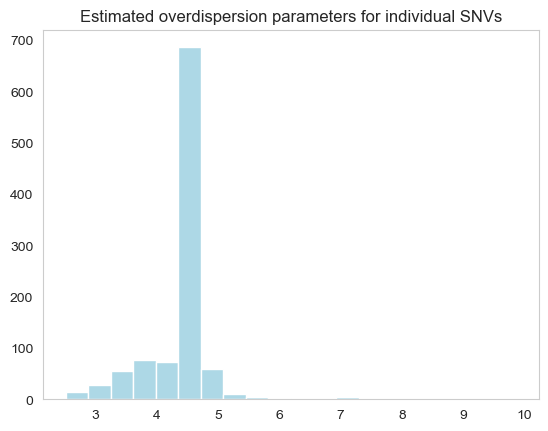

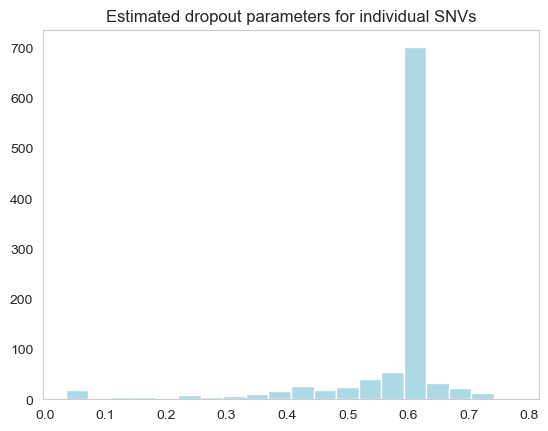

In [353]:
plt.hist(mean_overdispersions, bins=20, color='lightblue')
plt.title("Estimated overdispersion parameters for individual SNVs")
plt.grid(False)
# plt.savefig(os.path.join(path_bootstrap, "overdispersion_histogram.svg"), format="svg")
plt.show()

plt.hist(mean_dropouts, bins=20, color='lightblue')
plt.title("Estimated dropout parameters for individual SNVs")
plt.grid(False)
# plt.savefig(os.path.join(path_bootstrap, "dropout_histogram.svg"), format="svg")
plt.show()

In [354]:
samples = ["MM16", "MM34", "BC03", "BC07"]
global_parameters = {}

for s in samples:
    path_bootstrap = rf"../data/results/{s.lower()}/sciterna_bootstrap"
    global_parameters[s] = []
    for i in range(n_bootstrap):
        for j in range(n_rounds-1, n_rounds):
            global_param = np.loadtxt(os.path.join(path_bootstrap, "sciterna_global_parameters", f"sciterna_global_parameters_{j}r{i}.txt"))
            global_parameters[s].append(global_param)
    global_parameters[s] = np.array(global_parameters[s]) # Dropout, Overdispersion homozygous, Error Rate, Overdispersion heterozygous

In [386]:
# [0.62487553 5.96033547 0.01473082 4.11483504]

from src_python.mutation_filter import MutationFilter
from src_python.utils import load_config_and_set_random_seed

config = load_config_and_set_random_seed()

mf = MutationFilter(error_rate=config["error_rate"], overdispersion=config["overdispersion"],
                        genotype_freq=config["genotype_freq"], mut_freq=config["mut_freq"],
                        dropout_alpha=config["dropout_alpha"], dropout_beta=config["dropout_beta"],
                        dropout_direction_prob=config["dropout_direction"],
                        overdispersion_h=config["overdispersion_h"])

fixed_dropout_prob = 0.6248755
fixed_error_rate = 0.01473082

alt = np.loadtxt(r"C:\Users\Norio\Downloads\alt.txt", dtype=int)
ref = np.loadtxt(r"C:\Users\Norio\Downloads\ref.txt", dtype=int)
genotypes = np.loadtxt(r"C:\Users\Norio\Downloads\genotype.txt", dtype=str)

total = alt + ref
ind_nonzero = np.where(total != 0)[0]
non_H_indices = np.where(genotypes[ind_nonzero] == "H")[0]
valid_indices = ind_nonzero[non_H_indices]

genotypes_nonzero = genotypes[valid_indices]
alt_norm = alt[valid_indices]
total_norm = total[valid_indices]

od_values = np.linspace(2.5, 10, 30)
od_h_values = np.linspace(2.5, 10, 30)
OD, OD_H = np.meshgrid(od_values, od_h_values)

Z = np.zeros_like(OD)

for i in range(OD.shape[0]):
    print(i)
    for j in range(OD.shape[1]):
        params = [fixed_dropout_prob, OD[i, j], fixed_error_rate, OD_H[i, j]]
        # Z[i, j] = mf.total_log_posterior(params, alt_norm, total_norm, genotypes_nonzero)
        Z[i, j] = mf.total_log_likelihood(params, alt_norm, total_norm, genotypes_nonzero)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


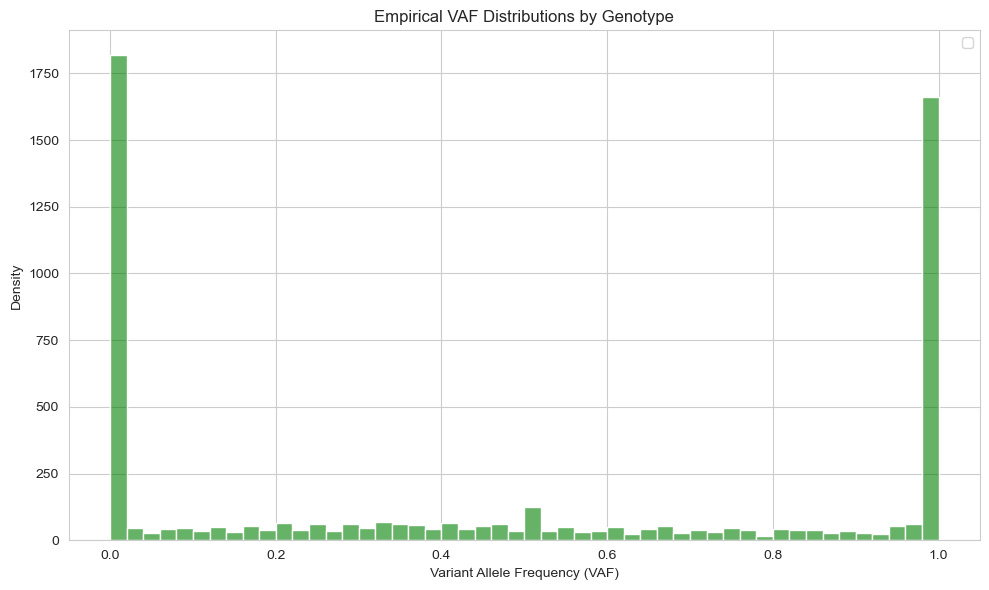

In [388]:
vaf = alt_norm / total_norm

vaf_H = vaf[genotypes_nonzero == "H"]
vaf_A = vaf[genotypes_nonzero == "A"]
vaf_R = vaf[genotypes_nonzero == "R"]

plt.figure(figsize=(10, 6))
sns.histplot(vaf_R, bins=50, color='blue', alpha=0.6)
sns.histplot(vaf_H, bins=50, color='green', alpha=0.6)
sns.histplot(vaf_A, bins=50, color='red', alpha=0.6)

plt.xlabel('Variant Allele Frequency (VAF)')
plt.ylabel('Density')
plt.title('Empirical VAF Distributions by Genotype')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

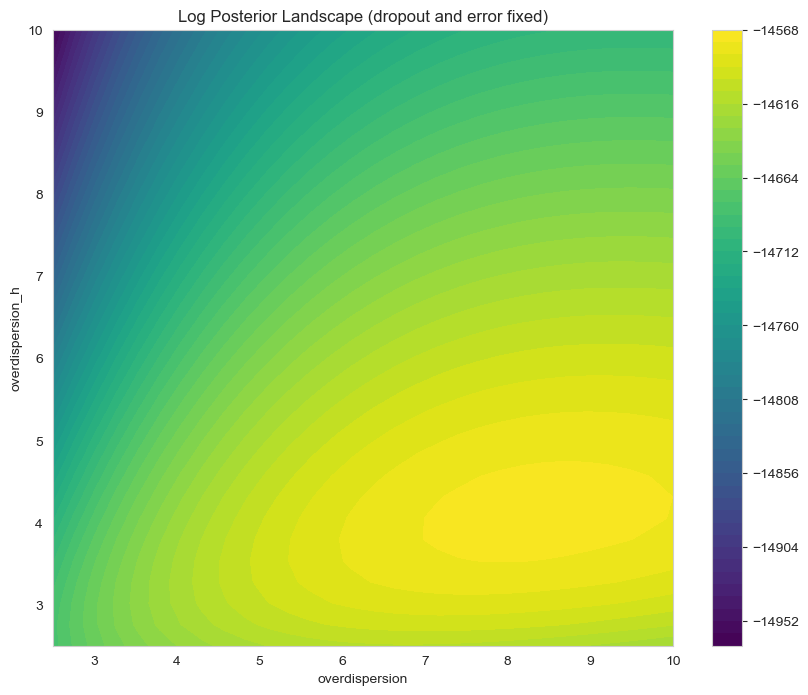

In [389]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
cp = plt.contourf(OD, OD_H, Z, levels=50, cmap='viridis')
plt.colorbar(cp)
plt.xlabel("overdispersion")
plt.ylabel("overdispersion_h")
plt.title("Log Posterior Landscape (dropout and error fixed)")
plt.show()

In [416]:
data = np.array([global_parameters[s][:, 3] for s in samples])
data2 = np.array([global_parameters[s][:, 2] for s in samples])

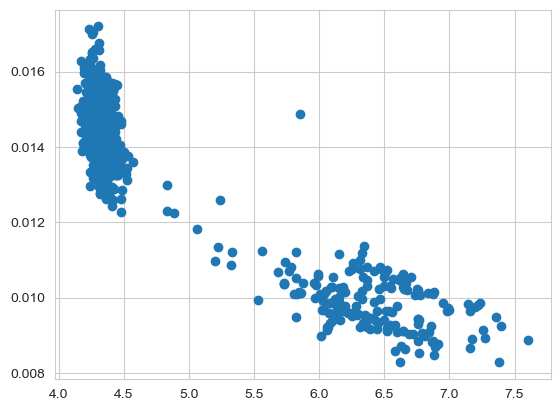

In [417]:
plt.scatter(data[0], data2[0])

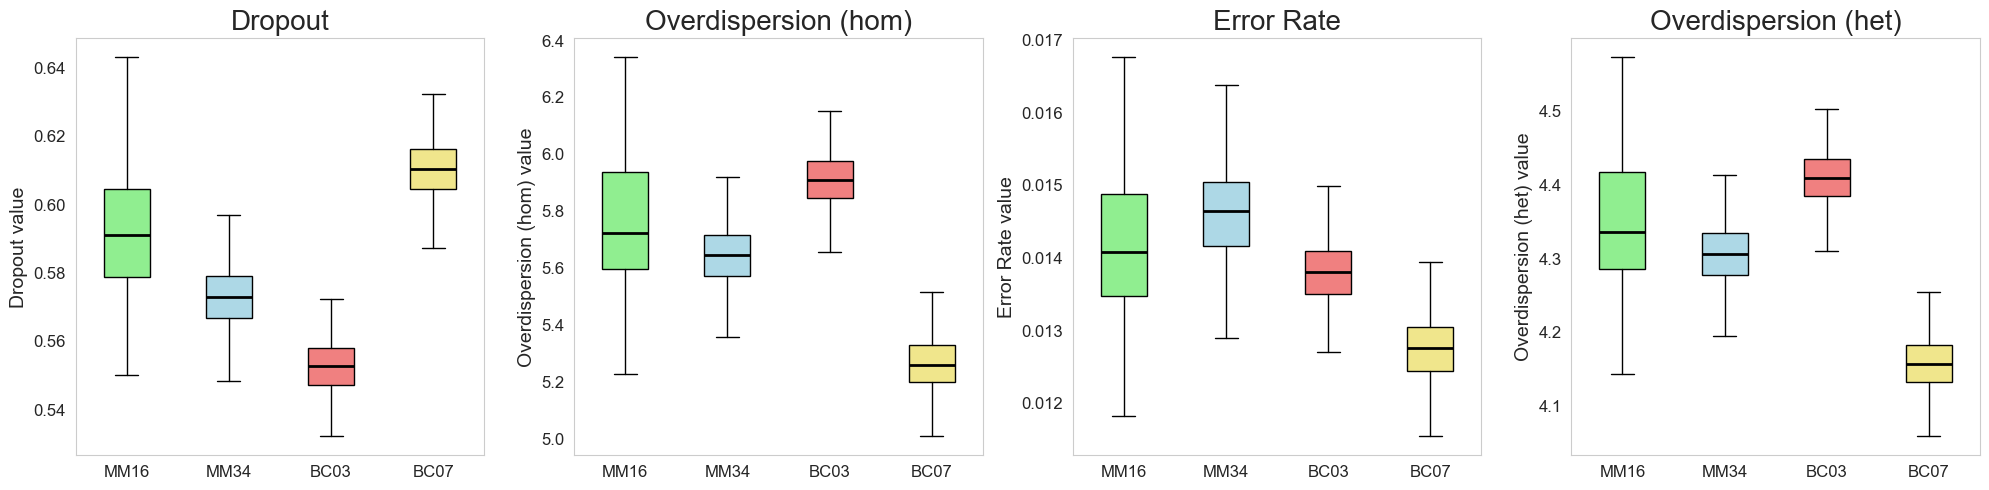

In [405]:
param_names = ["Dropout", "Overdispersion (hom)", "Error Rate", "Overdispersion (het)"]

for s in samples:
    global_parameters[s] = np.array(global_parameters[s])

# Plotting
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
box_colors = ['lightgreen', 'lightblue', 'lightcoral', 'khaki']

for idx, param_name in enumerate(param_names):
    # Collect values for this parameter across all samples
    data = [global_parameters[s][:, idx] for s in samples]
    bplot = axes[idx].boxplot(data, patch_artist=True, labels=samples, showfliers=False)

    # Color each box
    for patch, color in zip(bplot['boxes'], box_colors):
        patch.set_facecolor(color)
        patch.set_edgecolor('black')

    for median in bplot['medians']:
        median.set_color('black')
        median.set_linewidth(2)

    axes[idx].set_title(param_name, fontsize=20)
    axes[idx].set_ylabel(f"{param_name} value", fontsize=14)
    axes[idx].tick_params(axis='x', labelsize=12)
    axes[idx].tick_params(axis='y', labelsize=12)
    axes[idx].grid(False)

plt.tight_layout()
# plt.savefig(r"C:\Users\Norio\Documents\GitHub\SCITE-RNA-v2\data\results\figures\global_parameters.svg", format="svg")
plt.show()

In [357]:
selected_loci = np.loadtxt(rf"../data/results/{study_num}/sciterna_bootstrap/selected.txt", dtype=int)

ValueError: The number of FixedLocator locations (127), usually from a call to set_ticks, does not match the number of labels (46).

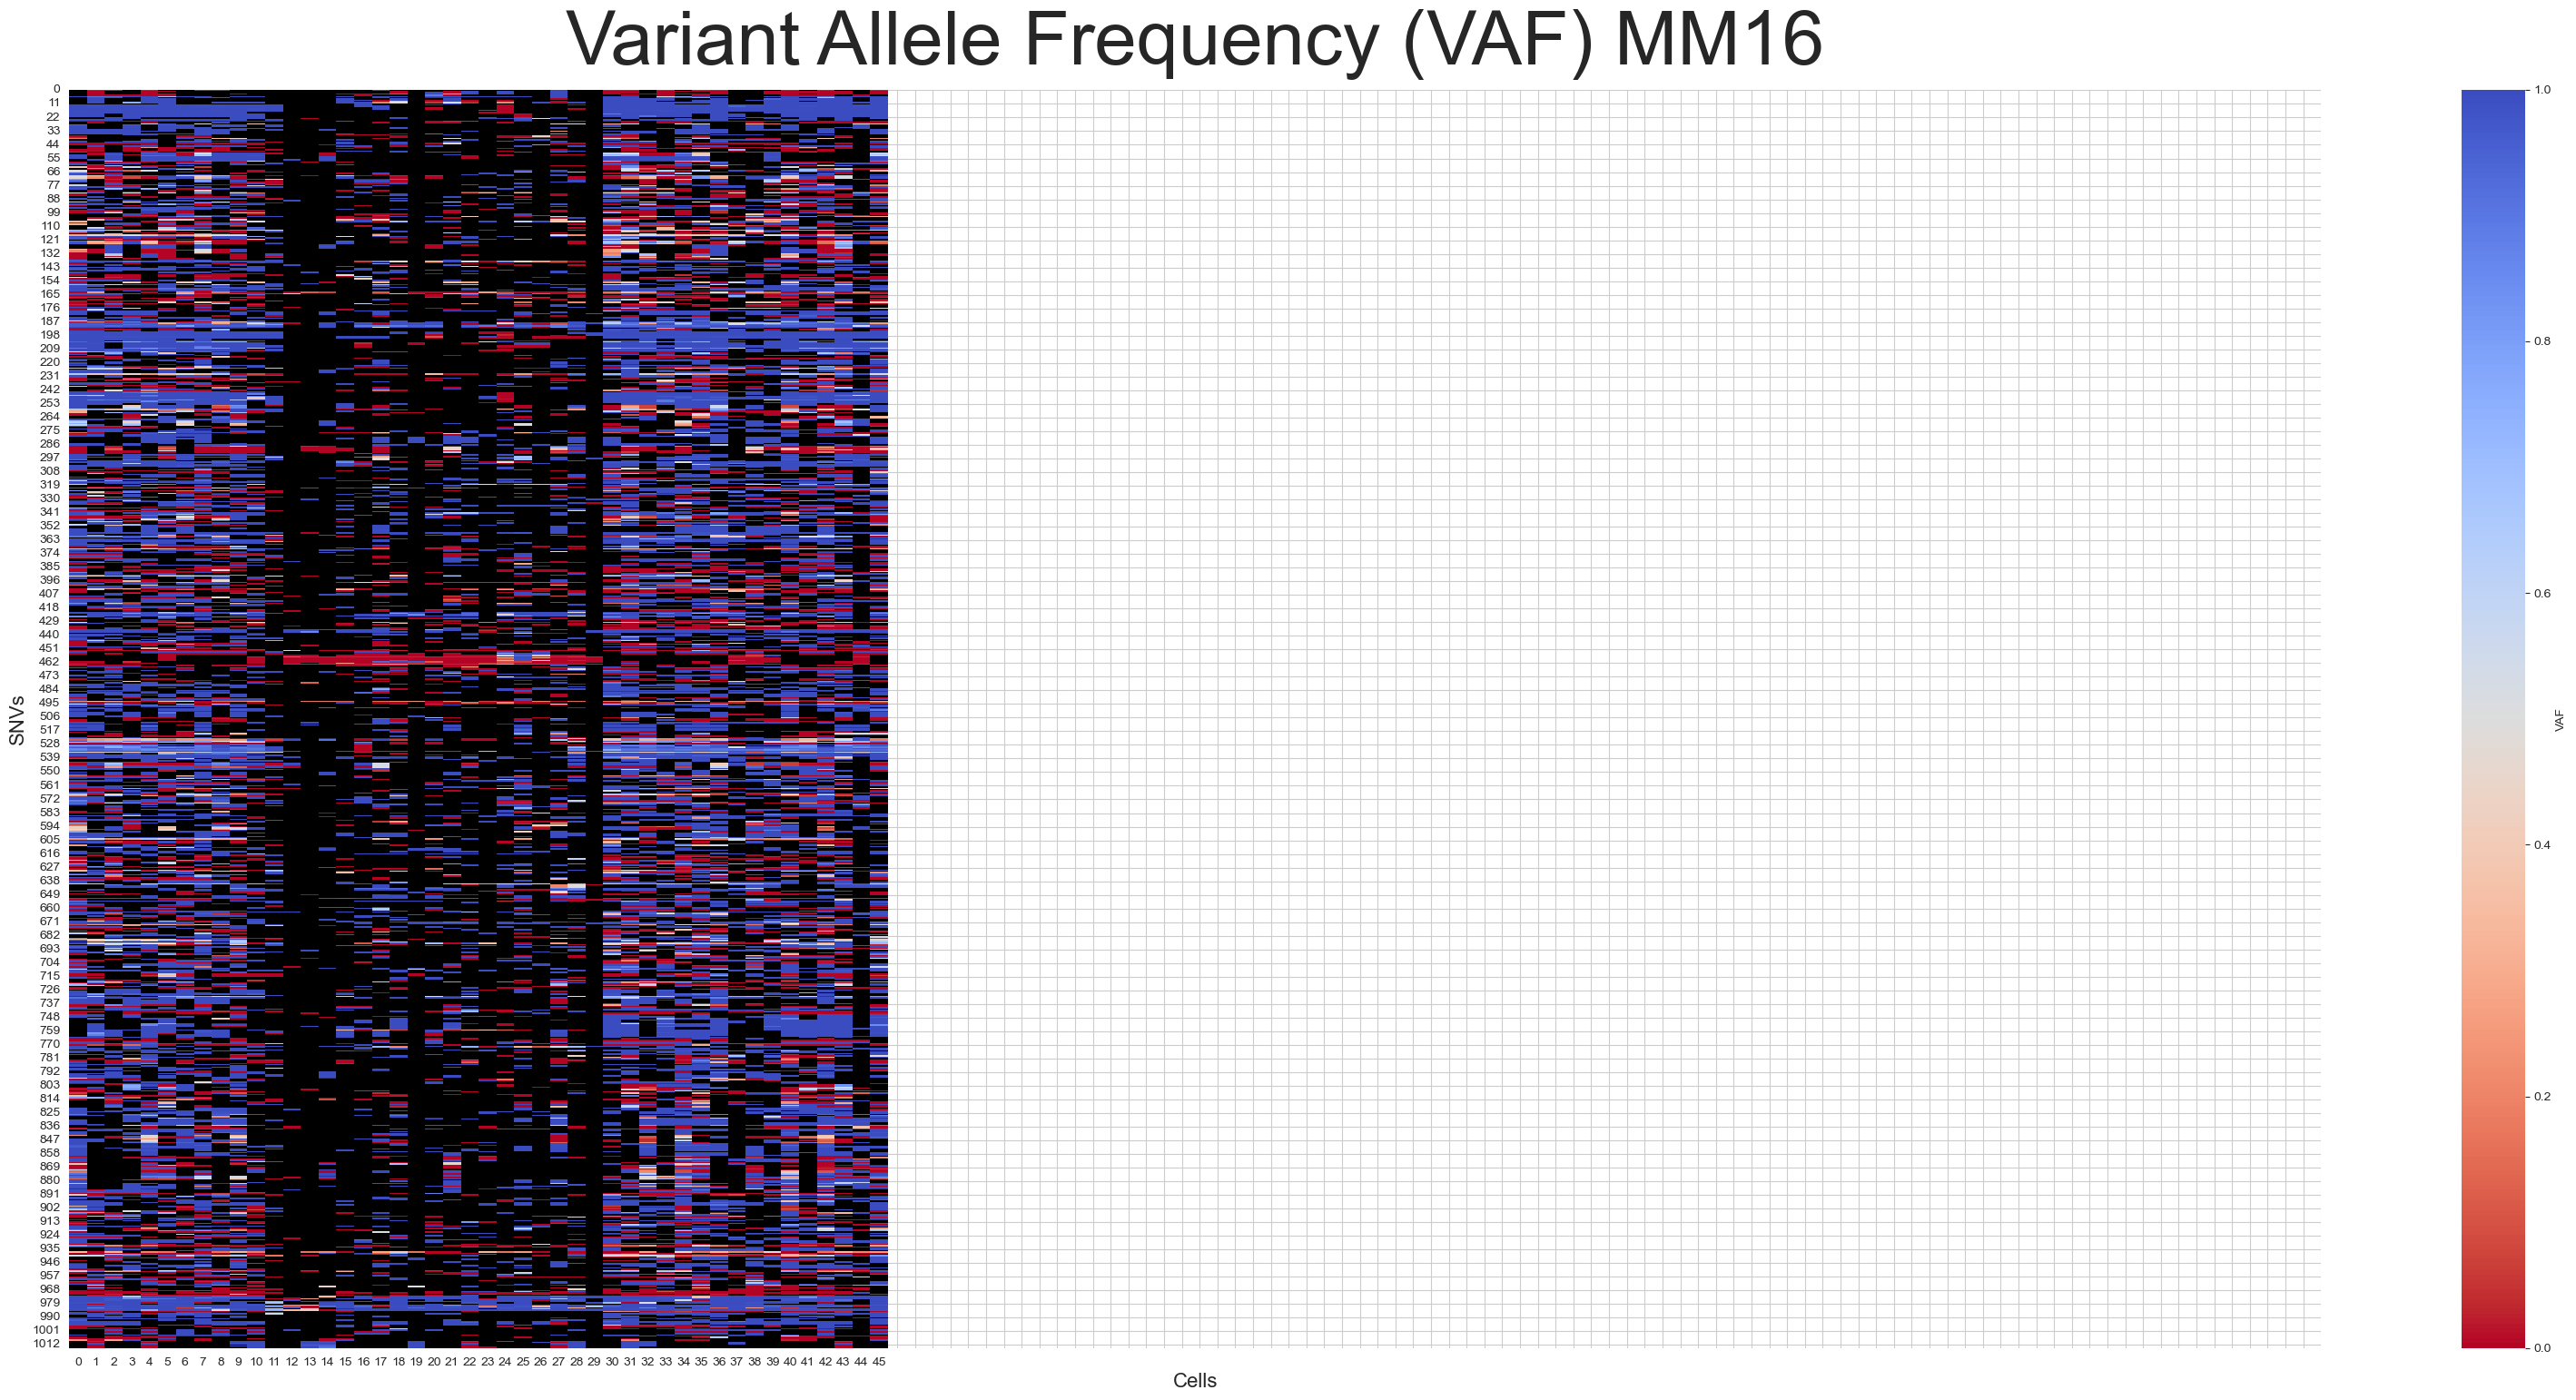

In [358]:
ref = np.array(pd.read_csv(os.path.join(f"../data/input_data/{study_num}", "ref.csv")))[:, 1:].astype(int)
alt = np.array(pd.read_csv(os.path.join(f"../data/input_data/{study_num}", "alt.csv")))[:, 1:].astype(int)

with np.errstate(divide='ignore', invalid='ignore'):
    vaf = alt[:,selected_loci] / (ref[:,selected_loci] + alt[:,selected_loci])

vaf = vaf[leaf_order].T  # Transpose for plotting (SNVs as rows)

# Define colormap: black for NaN, color gradient for valid values
base_cmap = plt.get_cmap("coolwarm_r")  # Or 'coolwarm', 'RdYlBu'
cmap_with_nan = base_cmap
cmap_with_nan.set_bad(color='black')

plt.figure(figsize=(40, 18))
ax = sns.heatmap(
    vaf,
    cmap=cmap_with_nan,
    vmin=0,
    vmax=1,
    cbar_kws={"label": "VAF"}
)
plt.title(f"Variant Allele Frequency (VAF) {study_num.upper()}", fontsize=60, pad=20)
plt.ylabel("SNVs", fontsize=16)
plt.xlabel("Cells", fontsize=16)

# Set x-axis tick label colors
ax.set_xticks(np.arange(len(indices_sorted)) + 0.5)
ax.set_xticklabels(sorted_df.columns, rotation=90)
for n, tick_label in enumerate(ax.get_xticklabels()):
    tick_label.set_color(col_colors[n])

plt.tight_layout()
plt.savefig(rf"../data/results/{study_num}/sciterna_bootstrap/vaf.png", format="png")
plt.show()

Finally we aim to find the genes with the most mutations

In [291]:
# with open("../data/input_data/gencode.v21.annotation.gtf", 'r') as file:
#     for line in file:
#         if line.startswith("#"):
#                 continue
#         fields = line.strip().split('\t')
#         if fields[2] == 'gene':
#             attributes = {key_value.split(' ')[0]: key_value.split(' ')[1].strip('"') for key_value in
#                           fields[8].split('; ') if key_value}
#             gene_names.append([fields[0], fields[3], fields[4], attributes["gene_name"]])
#
# df = pd.DataFrame(gene_names, columns=['chromosome', 'start', 'end', 'gene'])
# df['start'] = df['start'].astype(int)
# df['end'] = df['end'].astype(int)
# df.to_csv("../data/input_data/mm34/gene_positions.csv", index=False)

def convert_location_to_gene(locs):

    loc_to_gene = []

    df = pd.read_csv("../data/input_data/mm34/gene_positions.csv", index_col=False)
    for location in locs:
        chrom, pos = location.split(":")[0], location.split(":")[1]
        pos = int(pos)
        matching_rows = df[(df['chromosome'] == chrom) & (df['start'] <= pos) & (df['end'] >= pos)]
        matching_genes = matching_rows['gene'].tolist()
        loc_to_gene.append(matching_genes)

    return loc_to_gene

In [293]:
ref = pd.read_csv(os.path.join(f"../data/input_data/{study_num}", "ref.csv"))
selected_loci_pos = ref.columns[selected_loci]
selected_genes = convert_location_to_gene(selected_loci_pos)

In [294]:
genes = []
for s in selected_genes:
    genes.extend(s)
gens, cnt = np.unique(genes, return_counts=True)

print(cnt[np.argsort(cnt)][-30:])
print(gens[np.argsort(cnt)][-30:])

[4 4 4 4 4 4 5 5 5 5 5 5 5 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 8 9]
['NEAT1' 'ADAM19' 'FNDC3B' 'ACTR2' 'EIF2B5' 'TVP23B' 'SLC25A19' 'TMEM41B'
 'RRAGD' 'CDC42' 'ATF6' 'MIR29B1' 'C19orf48' 'AC016831.7' 'APOBEC3D'
 'MRPS10' 'SSR3' 'LINC-PINT' 'DLG1' 'IQGAP2' 'LDLR' 'VPS41' 'CPEB4'
 'AC092755.4' 'STT3B' 'BNIP2' 'MIR4435-1HG' 'SPC24' 'CCND2' 'CTSB']
